## SARIMA: Seasonal Autoregressive Integrated Moving Averages

In [1]:
# 필요한 library import
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

### 데이터 읽기와 포매팅

In [2]:
# 필요한 csv 파일 불러오기
df = pd.read_csv('monthly-milk-production.csv', index_col = 'Month', parse_dates = True)

In [3]:
# df 확인
df.head()

,pounds per cow
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [4]:
# df info 확인 (index가 datetimeindex인지 확인)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
pounds per cow    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


### Visualize the Data

In [5]:
# pounds per cow column을 timeseries로 추출
timeseries = df['pounds per cow']

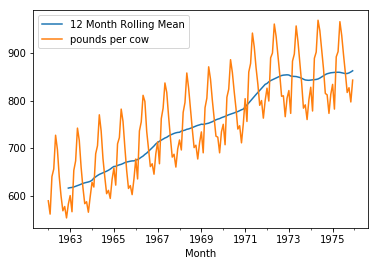

In [6]:
# timeseries의 값, 연평균 plot
timeseries.rolling(12).mean().plot(label = '12 Month Rolling Mean')
timeseries.plot()
plt.legend()

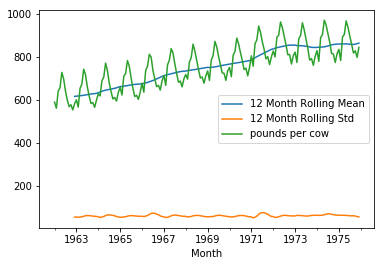

In [7]:
# timeseries의 값, 연평균, 연표준편차 plot
timeseries.rolling(12).mean().plot(label = '12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label = '12 Month Rolling Std')
timeseries.plot()
plt.legend()

### Decomposition

In [8]:
# df의 pounds per cow column을 decompose
decomposition = seasonal_decompose(df['pounds per cow'])

<Figure size 432x288 with 0 Axes>

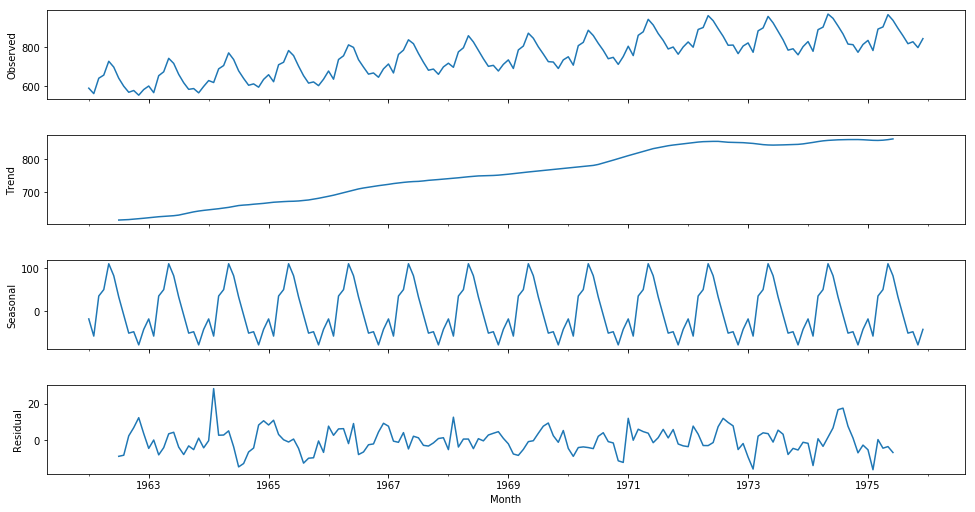

In [9]:
# decomposition plot
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

### Testing for stationarity

In [10]:
# pounds per cow column을 Augemented Dicky-Fuller(ADF) Test하여 stationary한지 확인
# 두번째 값이 p-value로 0.05보다 작으면 stationary
result = adfuller(df['pounds per cow'])
result

(-1.3038115874221246,
 0.627426708603034,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [11]:
# stationary인지 체크하는 함수 정의
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [12]:
# pounds per cow column이 stationary인지 확인
adf_check(df['pounds per cow'])

Non-Stationary 0.627426708603034


### Differencing

#### First Differencing

In [13]:
# 1차원 differentiate하여 1st diff column 생성 
df['1st diff'] = df['pounds per cow'] - df['pounds per cow'].shift(1)

In [14]:
# df 확인
df.head()

,pounds per cow,1st diff
Month,,
1962-01-01,589,NaN
1962-02-01,561,-28.0
1962-03-01,640,79.0
1962-04-01,656,16.0
1962-05-01,727,71.0


In [15]:
# 1st diff column이 stationary인지 확인
adf_check(df['1st diff'].dropna()) # 1st diff가 stationary이므로 d = 1

Stationary 0.03006800400178688


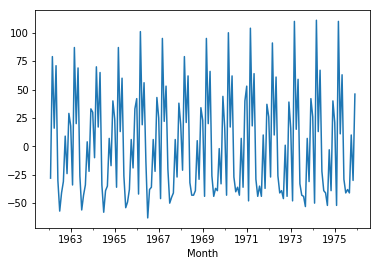

In [16]:
# 1st diff column plot
df['1st diff'].plot()

#### Second Differencing

In [17]:
# Second Differenciate하여 2nd diff column 생성
df['2nd diff'] = df['1st diff'] - df['1st diff'].shift(1)

In [18]:
# 2nd diff column이 stationary인지 확인
adf_check(df['2nd diff'].dropna())

Stationary 1.1126989332083069e-26


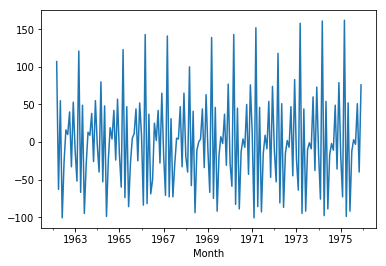

In [19]:
# 2nd diff column plot
df['2nd diff'].plot()

#### Seasonal Difference

In [20]:
# seasonal differentiate하여 seasonal diff column 생성
df['seasonal diff'] = df['pounds per cow'] - df['pounds per cow'].shift(12)

In [21]:
# seasonal diff column이 stationary인지 확인
adf_check(df['seasonal diff'].dropna())

Non-Stationary 0.16079880527711304


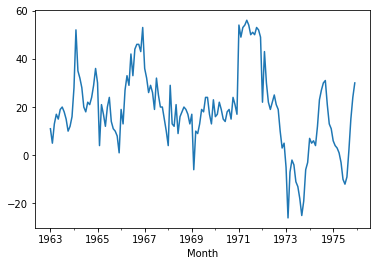

In [22]:
# seasonal diff column plot
df['seasonal diff'].plot()

#### Seasonal First Difference

In [23]:
# Seasonal first differentiate하여 seasonal 1st diff column 생성
df['seasonal 1st diff'] = df['1st diff'] - df['1st diff'].shift(12)

In [24]:
# seasonal 1st diff column이 stationary인지 확인
adf_check(df['seasonal 1st diff'].dropna()) # seasonal 1st diff가 stationary이므로 D = 1

Stationary 1.86542343187882e-05


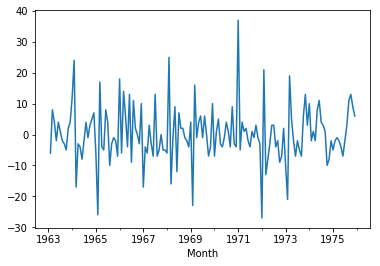

In [25]:
# seasonal 1st diff column plot
df['seasonal 1st diff'].plot()

### Autocorrelation and Partial Autocorrelation Plots

#### Autocorrelation Interpretation

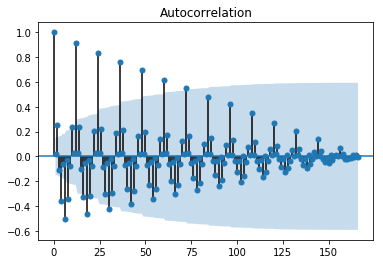

In [26]:
# 1st diff column의 acf plot
plot_acf(df['1st diff'].dropna()); # p = 0

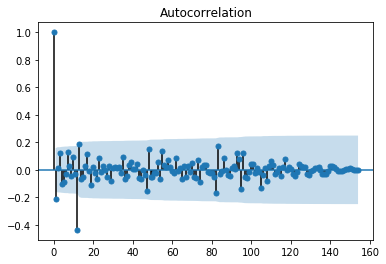

In [27]:
# seosonal 1st diff column의 acf plot
plot_acf(df['seasonal 1st diff'].dropna()); # P = 1

#### Partial Autocorrelation

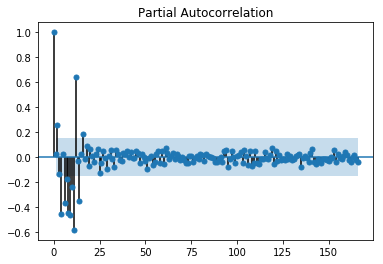

In [28]:
# 1st diff column의 pacf plot
plot_pacf(df['1st diff'].dropna(), method = 'ywm'); # q = 0

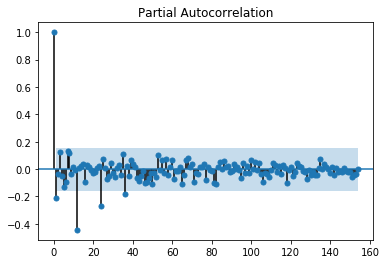

In [29]:
# seasonal 1st diff column의 pacf plot
plot_pacf(df['seasonal 1st diff'].dropna(), method = 'ywm'); # Q = 1

### SARIMA 모델

In [30]:
# SARIMA 모델 적용
model = sm.tsa.statespace.SARIMAX(df['pounds per cow'], order = (0, 1, 0), seasonal_order = (1, 1, 1, 12))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [31]:
# SARIMA 모델 fit
result = model.fit()

In [32]:
# SARIMA 모델 summary(AIC, BIC 중요)
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Thu, 28 Mar 2019   AIC                           1074.131
Time:                                    12:01:47   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

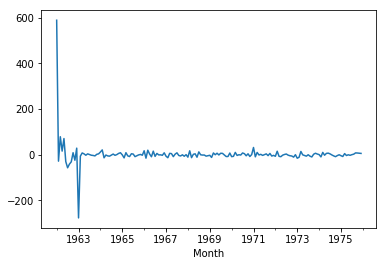

In [33]:
# SARIMA모델의 residual plot
result.resid.plot()

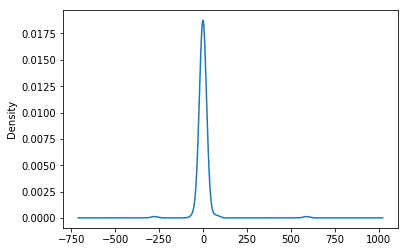

In [34]:
# SARIMA 모델의 Kernel Density Plot
result.resid.plot(kind = 'kde')

### Prediction of Future Values

In [35]:
# 150~168번째 값을 predict하여 forecast column 생성
df['forecast'] = result.predict(start = 150, end = 168, dynamic = True)

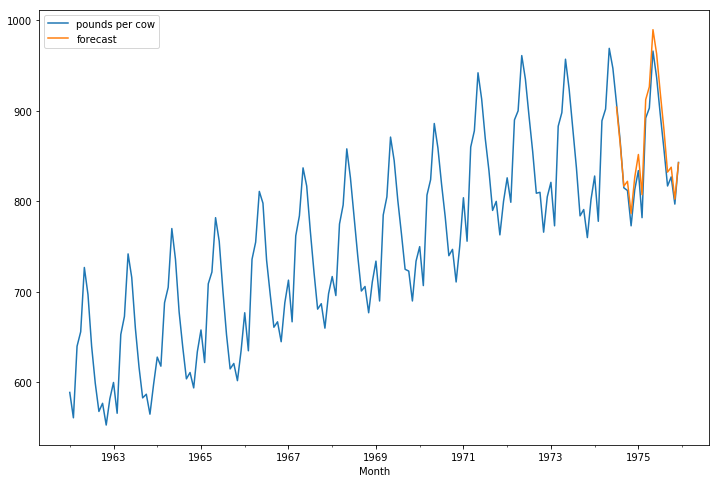

In [36]:
# pounds per cow, forecast column plot
df[['pounds per cow', 'forecast']].plot(figsize = (12, 8))